In [2]:
import importlib
import Custom_CNN
importlib.reload(Custom_CNN)
from Custom_CNN import CropDiseaseCNN,reset_weights

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset, Subset, random_split

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef

from tqdm import tqdm


In [3]:
BASE_SPLIT_PATH = r"C:\Users\azeem\PycharmProjects\ImageProcessingSemesterProject\Final_Split_Dataset+Generated"
TRAIN_DIR = os.path.join(BASE_SPLIT_PATH, 'Filtered_Train')
VAL_DIR = os.path.join(BASE_SPLIT_PATH, 'Filtered_Validation')

In [13]:
OUTPUT_DIR = "KFold_Final_Metrics"
BATCH_SIZE = 64
LR = 0.001
EPOCHS = 10
K_FOLDS = 5
SEED = 42
IMG_SIZE = 64
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_WORKERS = 4
model = CropDiseaseCNN(num_classes=38)

In [14]:
os.makedirs(OUTPUT_DIR, exist_ok=True)
torch.manual_seed(SEED)
np.random.seed(SEED)

In [22]:
base_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.4768168032169342, 0.5012436509132385, 0.4276201128959656], [0.17313140630722046, 0.1456347107887268, 0.19238317012786865])
])

full_raw = ConcatDataset([
    datasets.ImageFolder(TRAIN_DIR, transform=base_transform),
    datasets.ImageFolder(VAL_DIR, transform=base_transform)
])

test_size = int(0.1 * len(full_raw))
cv_size = len(full_raw) - test_size
cv_dataset, test_dataset = random_split(full_raw, [cv_size, test_size], generator=torch.Generator().manual_seed(SEED))

cv_indices = cv_dataset.indices
all_targets = np.array(full_raw.datasets[0].targets + full_raw.datasets[1].targets)
cv_labels = all_targets[cv_indices]
num_classes = len(full_raw.datasets[0].classes)

In [23]:
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=SEED)
scaler = torch.amp.GradScaler('cuda')
fold_metrics_storage = []

for fold, (train_idx_in_cv, val_idx_in_cv) in enumerate(skf.split(np.zeros(len(cv_labels)), cv_labels)):
    print(f'\n' + '='*70)
    print(f'🚀 STARTING FOLD {fold+1}/{K_FOLDS}')
    print('='*70)

    train_ids = [cv_indices[i] for i in train_idx_in_cv]
    val_ids = [cv_indices[i] for i in val_idx_in_cv]

    trainloader = DataLoader(Subset(full_raw, train_ids), batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
    valloader = DataLoader(Subset(full_raw, val_ids), batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

    model = CropDiseaseCNN(num_classes=num_classes).to(DEVICE)
    model.apply(reset_weights)
    optimizer = optim.AdamW(model.parameters(), lr=LR)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    best_fold_acc = 0.0
    best_metrics = {}

    for epoch in range(EPOCHS):
        # --- Training Phase ---
        model.train()
        train_loss, train_corrects = 0.0, 0
        train_bar = tqdm(trainloader, desc=f"Fold {fold+1} Ep {epoch+1} [Train]", leave=True)

        for inputs, labels in train_bar:
            inputs, labels = inputs.to(DEVICE, non_blocking=True), labels.to(DEVICE, non_blocking=True)
            optimizer.zero_grad(set_to_none=True)
            with torch.amp.autocast('cuda'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item() * inputs.size(0)
            train_corrects += torch.sum(torch.max(outputs, 1)[1] == labels.data)

        # --- Validation Phase ---
        model.eval()
        val_loss, val_corrects = 0.0, 0
        all_preds, all_true = [], []

        with torch.no_grad(), torch.amp.autocast('cuda'):
            for inputs, labels in valloader:
                inputs, labels = inputs.to(DEVICE, non_blocking=True), labels.to(DEVICE, non_blocking=True)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                preds = torch.max(outputs, 1)[1]
                all_preds.extend(preds.cpu().numpy())
                all_true.extend(labels.cpu().numpy())
                val_corrects += torch.sum(preds == labels.data)

        # --- Performance Summary ---
        avg_train_loss = train_loss / len(train_ids)
        avg_val_loss = val_loss / len(val_ids)

        train_acc = train_corrects.double() / len(train_ids) # <--- ADDED
        val_acc = val_corrects.double() / len(val_ids)

        epoch_f1 = f1_score(all_true, all_preds, average='macro', zero_division=0)
        epoch_mcc = matthews_corrcoef(all_true, all_preds)

        # Clean print statement including Training Accuracy
        print(f"➜ Epoch {epoch+1:02d}: "
              f"T-Loss: {avg_train_loss:.4f} | T-Acc: {train_acc:.4f} | "
              f"V-Loss: {avg_val_loss:.4f} | V-Acc: {val_acc:.4f} | "
              f"V-F1: {epoch_f1:.4f} | V-MCC: {epoch_mcc:.4f}")

        if val_acc > best_fold_acc:
            best_fold_acc = val_acc
            best_metrics = {
                'Fold': fold+1,
                'Best_Epoch': epoch+1,
                'Train_Acc': train_acc.item(),
                'Val_Accuracy': val_acc.item(),
                'Train_Loss': avg_train_loss,
                'Val_Loss': avg_val_loss,
                'Precision': precision_score(all_true, all_preds, average='macro', zero_division=0),
                'Recall': recall_score(all_true, all_preds, average='macro', zero_division=0),
                'F1': epoch_f1,
                'MCC': epoch_mcc
            }
            torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, f'best_fold_{fold+1}.pth'))

    fold_metrics_storage.append(best_metrics)


🚀 STARTING FOLD 1/5


Fold 1 Ep 1 [Train]: 100%|██████████| 893/893 [00:44<00:00, 20.15it/s]


➜ Epoch 01: T-Loss: 1.9380 | T-Acc: 0.5915 | V-Loss: 1.3123 | V-Acc: 0.8229 | V-F1: 0.8167 | V-MCC: 0.8187


Fold 1 Ep 2 [Train]: 100%|██████████| 893/893 [00:46<00:00, 19.31it/s]


➜ Epoch 02: T-Loss: 1.3357 | T-Acc: 0.8339 | V-Loss: 1.0240 | V-Acc: 0.9295 | V-F1: 0.9284 | V-MCC: 0.9277


Fold 1 Ep 3 [Train]: 100%|██████████| 893/893 [00:40<00:00, 21.95it/s]


➜ Epoch 03: T-Loss: 1.1875 | T-Acc: 0.8903 | V-Loss: 1.0211 | V-Acc: 0.9233 | V-F1: 0.9229 | V-MCC: 0.9214


Fold 1 Ep 4 [Train]: 100%|██████████| 893/893 [00:40<00:00, 22.06it/s]


➜ Epoch 04: T-Loss: 1.1068 | T-Acc: 0.9187 | V-Loss: 0.9577 | V-Acc: 0.9404 | V-F1: 0.9404 | V-MCC: 0.9389


Fold 1 Ep 5 [Train]: 100%|██████████| 893/893 [00:52<00:00, 17.13it/s]


➜ Epoch 05: T-Loss: 1.0559 | T-Acc: 0.9367 | V-Loss: 0.8901 | V-Acc: 0.9663 | V-F1: 0.9666 | V-MCC: 0.9654


Fold 1 Ep 6 [Train]: 100%|██████████| 893/893 [00:36<00:00, 24.74it/s]


➜ Epoch 06: T-Loss: 1.0177 | T-Acc: 0.9501 | V-Loss: 0.8599 | V-Acc: 0.9723 | V-F1: 0.9721 | V-MCC: 0.9716


Fold 1 Ep 7 [Train]: 100%|██████████| 893/893 [00:52<00:00, 16.86it/s]


➜ Epoch 07: T-Loss: 0.9911 | T-Acc: 0.9566 | V-Loss: 0.8588 | V-Acc: 0.9726 | V-F1: 0.9725 | V-MCC: 0.9718


Fold 1 Ep 8 [Train]: 100%|██████████| 893/893 [00:37<00:00, 23.98it/s]


➜ Epoch 08: T-Loss: 0.9691 | T-Acc: 0.9640 | V-Loss: 0.8436 | V-Acc: 0.9752 | V-F1: 0.9754 | V-MCC: 0.9746


Fold 1 Ep 9 [Train]: 100%|██████████| 893/893 [00:37<00:00, 23.55it/s]


➜ Epoch 09: T-Loss: 0.9509 | T-Acc: 0.9689 | V-Loss: 0.8317 | V-Acc: 0.9787 | V-F1: 0.9786 | V-MCC: 0.9782


Fold 1 Ep 10 [Train]: 100%|██████████| 893/893 [00:37<00:00, 24.02it/s]


➜ Epoch 10: T-Loss: 0.9338 | T-Acc: 0.9745 | V-Loss: 0.8257 | V-Acc: 0.9828 | V-F1: 0.9829 | V-MCC: 0.9823

🚀 STARTING FOLD 2/5


Fold 2 Ep 1 [Train]: 100%|██████████| 893/893 [00:37<00:00, 24.05it/s]


➜ Epoch 01: T-Loss: 1.9252 | T-Acc: 0.6004 | V-Loss: 1.2586 | V-Acc: 0.8425 | V-F1: 0.8390 | V-MCC: 0.8385


Fold 2 Ep 2 [Train]: 100%|██████████| 893/893 [00:36<00:00, 24.20it/s]


➜ Epoch 02: T-Loss: 1.3359 | T-Acc: 0.8305 | V-Loss: 1.0528 | V-Acc: 0.9154 | V-F1: 0.9142 | V-MCC: 0.9133


Fold 2 Ep 3 [Train]: 100%|██████████| 893/893 [00:36<00:00, 24.20it/s]


➜ Epoch 03: T-Loss: 1.1930 | T-Acc: 0.8872 | V-Loss: 0.9784 | V-Acc: 0.9410 | V-F1: 0.9412 | V-MCC: 0.9395


Fold 2 Ep 4 [Train]: 100%|██████████| 893/893 [00:37<00:00, 24.05it/s]


➜ Epoch 04: T-Loss: 1.1085 | T-Acc: 0.9183 | V-Loss: 0.9361 | V-Acc: 0.9491 | V-F1: 0.9493 | V-MCC: 0.9478


Fold 2 Ep 5 [Train]: 100%|██████████| 893/893 [00:37<00:00, 23.80it/s]


➜ Epoch 05: T-Loss: 1.0556 | T-Acc: 0.9362 | V-Loss: 0.8911 | V-Acc: 0.9678 | V-F1: 0.9677 | V-MCC: 0.9670


Fold 2 Ep 6 [Train]: 100%|██████████| 893/893 [00:37<00:00, 24.12it/s]


➜ Epoch 06: T-Loss: 1.0207 | T-Acc: 0.9474 | V-Loss: 0.8907 | V-Acc: 0.9616 | V-F1: 0.9623 | V-MCC: 0.9607


Fold 2 Ep 7 [Train]: 100%|██████████| 893/893 [00:37<00:00, 24.08it/s]


➜ Epoch 07: T-Loss: 0.9848 | T-Acc: 0.9591 | V-Loss: 0.8631 | V-Acc: 0.9686 | V-F1: 0.9686 | V-MCC: 0.9678


Fold 2 Ep 8 [Train]: 100%|██████████| 893/893 [00:37<00:00, 23.81it/s]


➜ Epoch 08: T-Loss: 0.9699 | T-Acc: 0.9624 | V-Loss: 0.8370 | V-Acc: 0.9793 | V-F1: 0.9794 | V-MCC: 0.9787


Fold 2 Ep 9 [Train]: 100%|██████████| 893/893 [00:37<00:00, 23.84it/s]


➜ Epoch 09: T-Loss: 0.9473 | T-Acc: 0.9690 | V-Loss: 0.8238 | V-Acc: 0.9812 | V-F1: 0.9812 | V-MCC: 0.9807


Fold 2 Ep 10 [Train]: 100%|██████████| 893/893 [00:37<00:00, 23.94it/s]


➜ Epoch 10: T-Loss: 0.9324 | T-Acc: 0.9730 | V-Loss: 0.8526 | V-Acc: 0.9677 | V-F1: 0.9673 | V-MCC: 0.9669

🚀 STARTING FOLD 3/5


Fold 3 Ep 1 [Train]: 100%|██████████| 893/893 [00:37<00:00, 23.67it/s]


➜ Epoch 01: T-Loss: 1.9404 | T-Acc: 0.5921 | V-Loss: 1.2586 | V-Acc: 0.8423 | V-F1: 0.8384 | V-MCC: 0.8384


Fold 3 Ep 2 [Train]: 100%|██████████| 893/893 [00:37<00:00, 24.06it/s]


➜ Epoch 02: T-Loss: 1.3504 | T-Acc: 0.8241 | V-Loss: 1.0773 | V-Acc: 0.9029 | V-F1: 0.9018 | V-MCC: 0.9004


Fold 3 Ep 3 [Train]: 100%|██████████| 893/893 [00:37<00:00, 23.92it/s]


➜ Epoch 03: T-Loss: 1.1978 | T-Acc: 0.8836 | V-Loss: 0.9890 | V-Acc: 0.9345 | V-F1: 0.9353 | V-MCC: 0.9329


Fold 3 Ep 4 [Train]: 100%|██████████| 893/893 [00:37<00:00, 23.95it/s]


➜ Epoch 04: T-Loss: 1.1156 | T-Acc: 0.9151 | V-Loss: 0.9663 | V-Acc: 0.9397 | V-F1: 0.9398 | V-MCC: 0.9382


Fold 3 Ep 5 [Train]: 100%|██████████| 893/893 [00:37<00:00, 23.76it/s]


➜ Epoch 05: T-Loss: 1.0615 | T-Acc: 0.9342 | V-Loss: 0.9209 | V-Acc: 0.9532 | V-F1: 0.9540 | V-MCC: 0.9520


Fold 3 Ep 6 [Train]: 100%|██████████| 893/893 [00:37<00:00, 24.04it/s]


➜ Epoch 06: T-Loss: 1.0238 | T-Acc: 0.9457 | V-Loss: 0.8973 | V-Acc: 0.9573 | V-F1: 0.9575 | V-MCC: 0.9562


Fold 3 Ep 7 [Train]: 100%|██████████| 893/893 [00:38<00:00, 23.36it/s]


➜ Epoch 07: T-Loss: 0.9965 | T-Acc: 0.9554 | V-Loss: 0.8718 | V-Acc: 0.9681 | V-F1: 0.9682 | V-MCC: 0.9672


Fold 3 Ep 8 [Train]: 100%|██████████| 893/893 [00:37<00:00, 23.78it/s]


➜ Epoch 08: T-Loss: 0.9711 | T-Acc: 0.9630 | V-Loss: 0.8753 | V-Acc: 0.9682 | V-F1: 0.9687 | V-MCC: 0.9674


Fold 3 Ep 9 [Train]: 100%|██████████| 893/893 [00:37<00:00, 23.65it/s]


➜ Epoch 09: T-Loss: 0.9501 | T-Acc: 0.9699 | V-Loss: 0.8333 | V-Acc: 0.9816 | V-F1: 0.9818 | V-MCC: 0.9811


Fold 3 Ep 10 [Train]: 100%|██████████| 893/893 [00:37<00:00, 24.07it/s]


➜ Epoch 10: T-Loss: 0.9347 | T-Acc: 0.9728 | V-Loss: 0.8213 | V-Acc: 0.9793 | V-F1: 0.9794 | V-MCC: 0.9787

🚀 STARTING FOLD 4/5


Fold 4 Ep 1 [Train]: 100%|██████████| 893/893 [00:37<00:00, 23.84it/s]


➜ Epoch 01: T-Loss: 1.9266 | T-Acc: 0.5962 | V-Loss: 1.3156 | V-Acc: 0.8238 | V-F1: 0.8174 | V-MCC: 0.8198


Fold 4 Ep 2 [Train]: 100%|██████████| 893/893 [00:37<00:00, 24.02it/s]


➜ Epoch 02: T-Loss: 1.3352 | T-Acc: 0.8295 | V-Loss: 1.1578 | V-Acc: 0.8799 | V-F1: 0.8792 | V-MCC: 0.8770


Fold 4 Ep 3 [Train]: 100%|██████████| 893/893 [00:37<00:00, 23.70it/s]


➜ Epoch 03: T-Loss: 1.1772 | T-Acc: 0.8918 | V-Loss: 0.9470 | V-Acc: 0.9507 | V-F1: 0.9510 | V-MCC: 0.9495


Fold 4 Ep 4 [Train]: 100%|██████████| 893/893 [00:37<00:00, 24.00it/s]


➜ Epoch 04: T-Loss: 1.1032 | T-Acc: 0.9197 | V-Loss: 0.9636 | V-Acc: 0.9394 | V-F1: 0.9406 | V-MCC: 0.9379


Fold 4 Ep 5 [Train]: 100%|██████████| 893/893 [00:37<00:00, 24.09it/s]


➜ Epoch 05: T-Loss: 1.0558 | T-Acc: 0.9355 | V-Loss: 0.8989 | V-Acc: 0.9600 | V-F1: 0.9604 | V-MCC: 0.9589


Fold 4 Ep 6 [Train]: 100%|██████████| 893/893 [00:37<00:00, 24.03it/s]


➜ Epoch 06: T-Loss: 1.0187 | T-Acc: 0.9478 | V-Loss: 0.8674 | V-Acc: 0.9702 | V-F1: 0.9704 | V-MCC: 0.9694


Fold 4 Ep 7 [Train]: 100%|██████████| 893/893 [00:37<00:00, 24.10it/s]


➜ Epoch 07: T-Loss: 0.9902 | T-Acc: 0.9572 | V-Loss: 0.8595 | V-Acc: 0.9747 | V-F1: 0.9747 | V-MCC: 0.9741


Fold 4 Ep 8 [Train]: 100%|██████████| 893/893 [00:36<00:00, 24.30it/s]


➜ Epoch 08: T-Loss: 0.9675 | T-Acc: 0.9648 | V-Loss: 0.8335 | V-Acc: 0.9817 | V-F1: 0.9817 | V-MCC: 0.9812


Fold 4 Ep 9 [Train]: 100%|██████████| 893/893 [00:37<00:00, 24.09it/s]


➜ Epoch 09: T-Loss: 0.9485 | T-Acc: 0.9693 | V-Loss: 0.8098 | V-Acc: 0.9848 | V-F1: 0.9849 | V-MCC: 0.9844


Fold 4 Ep 10 [Train]: 100%|██████████| 893/893 [00:36<00:00, 24.23it/s]


➜ Epoch 10: T-Loss: 0.9329 | T-Acc: 0.9738 | V-Loss: 0.8060 | V-Acc: 0.9839 | V-F1: 0.9841 | V-MCC: 0.9835

🚀 STARTING FOLD 5/5


Fold 5 Ep 1 [Train]: 100%|██████████| 893/893 [00:36<00:00, 24.22it/s]


➜ Epoch 01: T-Loss: 1.9141 | T-Acc: 0.6040 | V-Loss: 1.2481 | V-Acc: 0.8479 | V-F1: 0.8470 | V-MCC: 0.8441


Fold 5 Ep 2 [Train]: 100%|██████████| 893/893 [00:37<00:00, 23.89it/s]


➜ Epoch 02: T-Loss: 1.3231 | T-Acc: 0.8379 | V-Loss: 1.0949 | V-Acc: 0.8981 | V-F1: 0.8967 | V-MCC: 0.8956


Fold 5 Ep 3 [Train]: 100%|██████████| 893/893 [00:37<00:00, 23.98it/s]


➜ Epoch 03: T-Loss: 1.1775 | T-Acc: 0.8931 | V-Loss: 0.9767 | V-Acc: 0.9387 | V-F1: 0.9393 | V-MCC: 0.9371


Fold 5 Ep 4 [Train]: 100%|██████████| 893/893 [00:36<00:00, 24.26it/s]


➜ Epoch 04: T-Loss: 1.1020 | T-Acc: 0.9214 | V-Loss: 0.9263 | V-Acc: 0.9534 | V-F1: 0.9538 | V-MCC: 0.9522


Fold 5 Ep 5 [Train]: 100%|██████████| 893/893 [00:36<00:00, 24.23it/s]


➜ Epoch 05: T-Loss: 1.0554 | T-Acc: 0.9355 | V-Loss: 0.9543 | V-Acc: 0.9400 | V-F1: 0.9397 | V-MCC: 0.9385


Fold 5 Ep 6 [Train]: 100%|██████████| 893/893 [00:37<00:00, 24.13it/s]


➜ Epoch 06: T-Loss: 1.0159 | T-Acc: 0.9511 | V-Loss: 0.8695 | V-Acc: 0.9707 | V-F1: 0.9708 | V-MCC: 0.9699


Fold 5 Ep 7 [Train]: 100%|██████████| 893/893 [00:36<00:00, 24.23it/s]


➜ Epoch 07: T-Loss: 0.9907 | T-Acc: 0.9584 | V-Loss: 0.8809 | V-Acc: 0.9658 | V-F1: 0.9653 | V-MCC: 0.9649


Fold 5 Ep 8 [Train]: 100%|██████████| 893/893 [00:37<00:00, 23.88it/s]


➜ Epoch 08: T-Loss: 0.9667 | T-Acc: 0.9652 | V-Loss: 0.8291 | V-Acc: 0.9805 | V-F1: 0.9805 | V-MCC: 0.9800


Fold 5 Ep 9 [Train]: 100%|██████████| 893/893 [00:37<00:00, 24.10it/s]


➜ Epoch 09: T-Loss: 0.9502 | T-Acc: 0.9700 | V-Loss: 0.8383 | V-Acc: 0.9755 | V-F1: 0.9756 | V-MCC: 0.9749


Fold 5 Ep 10 [Train]: 100%|██████████| 893/893 [00:36<00:00, 24.18it/s]


➜ Epoch 10: T-Loss: 0.9328 | T-Acc: 0.9745 | V-Loss: 0.8273 | V-Acc: 0.9793 | V-F1: 0.9793 | V-MCC: 0.9787


In [24]:
results_df = pd.DataFrame(fold_metrics_storage)
results_df.to_csv(os.path.join(OUTPUT_DIR, "kfold_detailed_performance.csv"), index=False)

print("\n" + "="*30)
print(f"K-FOLD COMPLETE. RESULTS SAVED.")
print("="*30)


K-FOLD COMPLETE. RESULTS SAVED.


In [25]:
csv_path = os.path.join("KFold_Final_Metrics", "kfold_detailed_performance.csv")

if os.path.exists(csv_path):
    results_df = pd.read_csv(csv_path)

    cols_to_analyze = [
        'Train_Acc', 'Val_Accuracy', 'Train_Loss',
        'Val_Loss', 'Precision', 'Recall', 'F1', 'MCC'
    ]

    available_cols = [c for c in cols_to_analyze if c in results_df.columns]
    metrics_df = results_df[available_cols]

    summary_stats = pd.DataFrame({
        'Mean': metrics_df.mean(),
        'Std_Dev': metrics_df.std()
    })

    print("\n" + "="*40)
    print("      K-FOLD AGGREGATE PERFORMANCE")
    print("="*40)
    print(summary_stats.round(4))
    print("="*40)

    summary_stats.to_csv(os.path.join("KFold_Final_Metrics", "kfold_summary_statistics.csv"))
    print(f"\nSummary saved to: {os.path.join('KFold_Final_Metrics', 'kfold_summary_statistics.csv')}")

else:
    print(f"Error: Could not find the file at {csv_path}")
    print("Please ensure you have run the training script first.")


      K-FOLD AGGREGATE PERFORMANCE
                Mean  Std_Dev
Train_Acc     0.9696   0.0033
Val_Accuracy  0.9822   0.0017
Train_Loss    0.9493   0.0117
Val_Loss      0.8243   0.0089
Precision     0.9826   0.0017
Recall        0.9823   0.0017
F1            0.9823   0.0017
MCC           0.9817   0.0017

Summary saved to: KFold_Final_Metrics\kfold_summary_statistics.csv


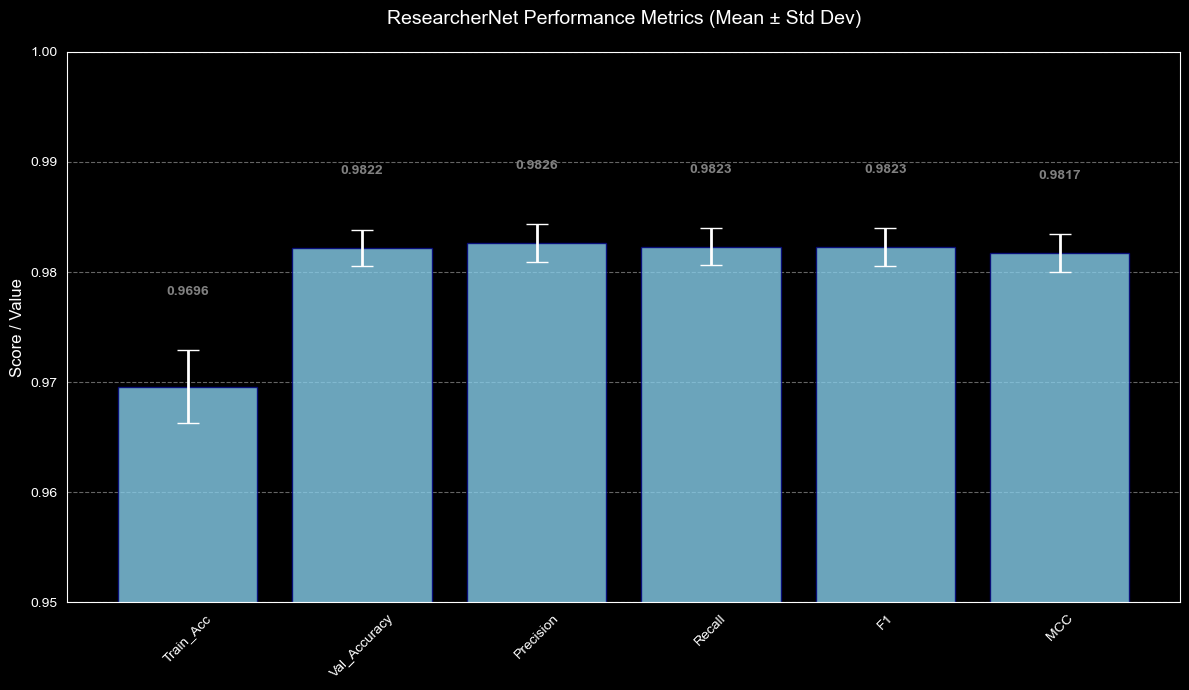

In [57]:
csv_path = os.path.join("KFold_Final_Metrics", "kfold_summary_statistics.csv")
results_df = pd.read_csv(csv_path)

results_df = results_df.drop([2,3])
results_df = results_df.reset_index(drop=True)

metrics = results_df['Metric'].tolist()
means = results_df['Mean']
stds = results_df['Std_Dev']

plt.figure(figsize=(12, 7))
error_style = {
    'ecolor': 'white',      # This changes the white lines you see in your image
    'elinewidth': 2,        # Thickness of the vertical line
    'capsize': 8,           # Width of the horizontal cap
}
# Create bars
bars = plt.bar(metrics, means, yerr=stds, capsize=8,error_kw=error_style,
               color='skyblue', edgecolor='navy', alpha=0.8)

# Adjust ylim to show the lowest value (Val_Loss at 0.82) up to 1.0
plt.ylim(0.95, 1.0)

plt.title('ResearcherNet Performance Metrics (Mean ± Std Dev)', fontsize=14, pad=20)
plt.ylabel('Score / Value', fontsize=12)
plt.xticks(rotation=45) # Rotate labels so they don't overlap
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.gca().xaxis.grid(False)
# Add text labels on top of bars
for i, v in enumerate(means):
    # Offset the text slightly above the error bar
    label_y = v + stds[i] + 0.005
    plt.text(i, label_y, f"{v:.4f}", ha='center', fontweight='bold', fontsize=10,color='grey')

plt.tight_layout()
plt.show()